## Load DataFrame

In [1]:
!gdown --id 13Qm6ztAmVyBHvo_mch6gk-2VYKUHeRuu

Downloading...
From: https://drive.google.com/uc?id=13Qm6ztAmVyBHvo_mch6gk-2VYKUHeRuu
To: /content/inno_stats.tar.gz
1.91GB [00:10, 175MB/s]


In [5]:
!tar -xf inno_stats.tar.gz

In [1]:
import pandas as pd

In [2]:
bad_ids = pd.read_csv('bad_ids.csv')

In [4]:
bad_ids.head()

,Unnamed: 0,id_card
0,0,806096
1,1,1438102
2,2,72344
3,3,427981
4,4,1528414


In [3]:
bad_ids_set = set(bad_ids['id_card'])

In [4]:
df = pd.read_csv('09_groups.csv')

In [6]:
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100858 entries, 0 to 42100857
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   id_doc    int64  
 2   id_order  float64
 3   id_card   int64  
 4   id_tov    int64  
 5   id_kontr  int64  
 6   quantity  float64
 7   sum       float64
 8   is_green  int64  
 9   id_group  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 3.1+ GB


##Clean DataFrame

In [5]:
df_filtered = df[~df['id_card'].isin(bad_ids_set)]

In [9]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38466003 entries, 0 to 42100857
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   id_doc    int64  
 2   id_order  float64
 3   id_card   int64  
 4   id_tov    int64  
 5   id_kontr  int64  
 6   quantity  float64
 7   sum       float64
 8   is_green  int64  
 9   id_group  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 3.2+ GB


##Experiments

###1) Prove that buying discounted products depends on the average order sum.

In [21]:

discount_destr = df_filtered[df_filtered['is_green'] == 1].groupby(by=['id_doc']).sum()['sum']
discount_mean_sum = discount_destr.mean()
discount_mean_sum

190.68263650300798

In [22]:
discounted_count = len(df_filtered[df_filtered['is_green'] == 1])
discounted_count

2611563

In [23]:
non_discount_destr = df_filtered[df_filtered['is_green'] == 0].sample(n=discounted_count).groupby(by=['id_doc']).sum()['sum']
non_discount_mean_sum = non_discount_destr.mean()
non_discount_mean_sum

156.4386019430168

Calculate statistic

In [24]:
from scipy.stats import ttest_ind

ttest_ind(discount_destr, non_discount_destr)

Ttest_indResult(statistic=162.59100004974962, pvalue=0.0)

Therefore we have discounted products mean sum in one check is higher than non discounted. Proved.

### 2) Prove that the frequency of shopping grows around the wage taking days

Lets plot overall spending durgin each day

In [27]:
df_filtered.index = pd.to_datetime(df_filtered['date'],format='%Y-%m-%d %H:%M:%S')
df_filtered

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
date,,,,,,,,,,
2020-09-01 17:01:25,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
2020-09-01 17:35:36,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2020-09-01 19:19:21,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
2020-09-01 21:53:34,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
2020-09-01 18:42:31,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
...,...,...,...,...,...,...,...,...,...,...
2020-09-30 11:26:28,2020-09-30 11:26:28,4850561,0.0,1739990,25292,17528,1.0,130.00,0,10099
2020-09-30 08:12:39,2020-09-30 08:12:39,10015419,0.0,1761351,30740,19188,2.0,120.00,0,10008
2020-09-30 09:54:24,2020-09-30 09:54:24,22816791,0.0,1432778,30741,19188,1.0,73.00,0,10254


In [31]:
sum_of_spendings = df_filtered.groupby(by=[df_filtered.index.day])['id_doc'].count()

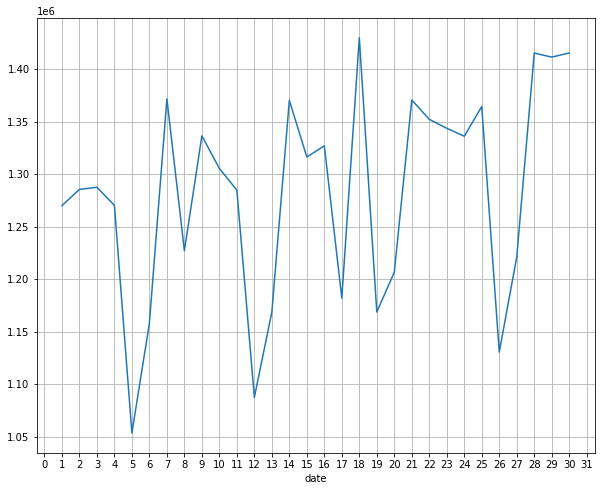

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.locator_params(axis="x", nbins=50)
sum_of_spendings.plot()
plt.grid()

so we can see that from 5th and 20th days of the mouth the number of purchases are increased 

### Frequent buyers 

In [6]:
frequent_buyers = df_filtered.groupby(by=['id_doc']).first()
frequent_buyers['id_card'].value_counts()[:100]

620767     161
1523082    119
943480     109
1567258    104
1808366    103
          ... 
1855576     61
474437      61
1304277     61
1516308     61
341072      61
Name: id_card, Length: 100, dtype: int64